<a href="https://colab.research.google.com/github/denocris/Basics-of-deep-learning-for-cv/blob/main/03_cnn_training_with_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> CNN Training with PyTorch </center></h1>



<center>  <img src="https://drive.google.com/uc?export=view&id=1D2O4x5i05Ztx0gUto5VOLJH_EQvDb5lt"width="800">  </center> 





## About this Lecture (Notebook Nr. 3)

In notebook nr. 1 and 2, we wrote from scratch a simple CNN model and manually set up its backpropagation. Then, to warm up with PyTorch, we implemented the same network to check the consistency of our numpy implementation. Now that we understood the basic mechanism, we are ready to build a more sophisticated CNN, LeNet, and train it using PyTorch. We will then learn cross-validation and grid search methods.

LeNet is a convolutional neural network structure proposed by [Yann LeCun et al. in 1998](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). Being one of the earliest CNNs, its structure is quite simple but defines the basic components of CNN.

### Tools used 

PyTorch, NumPy, sklearn. To perform grid search we will use the Optuna optimization library.

### Outline

* information theory background;
* explain overfitting and underfitting;
* introduce regularization techniques (Dropout, Batch Normalization, L1, L2);
* write and train LeNet on MNIST using hold-out validation;
* implement grid search with Optuna;
* learn k-fold cross-validation



## Packages and GPU Settings

In [ ]:
!pip install -q tensorboard
!pip install -q optuna 

     |████████████████████████████████| 235kB 8.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 7.9MB/s 
     |████████████████████████████████| 1.1MB 17.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 133kB 33.5MB/s 
     |████████████████████████████████| 112kB 47.3MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 


In [ ]:
import torch

import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchsummary import summary


from matplotlib import pyplot as plt
import numpy as np
import random
import optuna

GPU info e device set up

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Sep 10 14:18:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

As usual, to have reproducible results we choose a seed.

In [ ]:
# set the seed: built-in python, numpy, and pytorch
seed = 172
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # works for all devices (CPU and GPU)

## Information Theory Background 


Basic notions of Information Theory are essetial for the understanding of many machine/deep learning mechanisms as we will see in a while.

### Self-Information

Every event takes with it an ammount of self-information. The idea behind self-information goes as follows

* if an event always occurs, we associate it with a smaller amount of information. It will not suprise us!
* On the other side, a rare event is associated with a huge amount of information. It will suprise us!

I am not surprise to see the sunrise every morning (likely event). Instead,  I would be really suprised if tomorrow the Sun will not rise (unlikely event). This amount of surprise or self-information of the event $x$ is quantified by

$$I(x) = - \log p(x),$$

where $p(x)$ is the probability of the event $x$. If $p(x)=1$, then self-info is zero. A rare event instead has a huge surpise factor.

### Shannon Entropy 

Here the original paper by Claude Shannon (1948): [A Mathematical Theory of Communication](http://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf).

In terms of self-info, Shannon Entropy is the average self-information (expected value) over all possible values of X.
The entropy for a probability $p(x)$ distribution is

$$ S = - \sum_i p(x_i) \log p(x_i),$$

where we assume we know the probability $p$ for each outcome $i$ and $ \sum_i p(x_i)=1$. If we use $log_2$ for our calculation we can interpret entropy as *the minimum number of bits it would take us to encode our information*.

For continous variables, we can use the integral form

$$ S = - \int  p(x) \log p(x) \, dx,$$

where now $p(x)$ is taking the role of a probability density function (PDF). Take in mind that a broad probability density has higher entropy than a narrowed one (think about Gaussian distribution vs delta Dirac, which has $S=0$).

In both discrete and continous formulation, we are computing the expectation (i.e. average) of the negative log-probability (i.e. self-info) which is the theoretical minimum encoding size of the information from the event $x$. The same formula is usually written as

$$S = \mathbb E _{\, x \sim p} \left[ -\log p(x) \right],$$

where $x \sim p$ means that we calculate the expectation with the probability distribution $p$.

Let's give an example! 

<!---
  REMIND to change open with uc
 https://drive.google.com/open?id=1Y52T3Z4dwRU4Rq5L5bEVYh0d3kU0aVB8
--->

  <center>  <img src=https://drive.google.com/uc?id=1GaAeK8xIZCVDRb-oHQNUzRuoOprFh1eS " width="700">  </center> 

Let us say we have to pass a message about what drink Cristiano will order during an event. In general, Cristiano loves [Midori Sour](https://drizly.com/midori-sour/r-b972d5282bec6fe8) , Daiquiri, Spritz and Wine.

On Monday, Cristiano loves to listen Jazz and the probability distribution of his choice is: 

$$P(\text Midori ) =  P(\text Daiquiri ) = P(\text Spritz ) = P(\text Wine ) = 0.25,$$

while the corresponding entropy

$$S = - \frac{1}{4} \log \frac{1}{4} - \frac{1}{4} \log \frac{1}{4} - \frac{1}{4} \log \frac{1}{4} - \frac{1}{4} \log \frac{1}{4} = 2$$

On Wednesday, he usually meets with some friends after work: 

$$P(\text Midori ) = 0.125,\;  P(\text Daiquiri ) =0.125,\;  P(\text Spritz ) = 0.5,\; P(\text  Wine ) = 0.25,$$

while the corresponding entropy

$$S = - \frac{1}{8} \log \frac{1}{8} - \frac{1}{8} \log \frac{1}{8} - \frac{1}{2} \log \frac{1}{2} - \frac{1}{4} \log \frac{1}{4} = 1.75$$


On Thursday, he often goes to an event where cocktail attire dress code is required

$$P(\text Midori ) = 0.95,\;  P(\text Daiquiri ) =0.02,\;  P(\text Spritz ) = 0.018,\; P(\text  Wine ) = 0.012,$$

and the corresponding entropy

$$S = - 0.95 \log 0.95 - 0.02 \log 0.02 - 0.018 \log 0.018 - 0.012 \log 0.012 = 0.364$$

In [ ]:
# On Monday, all drinks have equal probability to be chose
entropy_1 = -0.25*np.log2(0.25)-0.25*np.log2(0.25)-0.25*np.log2(0.25)-0.25*np.log2(0.25)
print('On Monday, high entropy: ', entropy_1)

# On Wednesday, some are more probable than others
entropy_2 = -0.5*np.log2(0.5)-0.25*np.log2(0.25)-0.125*np.log2(0.125)-0.125*np.log2(0.125)
print('On Wednesday, medium entropy: ', entropy_2)

# On Thursday, one drink is by far the most probable
entropy_3 = -0.95*np.log2(0.95)-0.02*np.log2(0.02)-0.018*np.log2(0.018)-0.012*np.log2(0.012)
print('On Thursday, low entropy: ', entropy_3)

On Monday, high entropy:  2.0
On Wednesday, medium entropy:  1.75
On Thursday, low entropy:  0.36407300467232967


If entropy is high (encoding size $log_2 p(x)$ is big on average), it means we have many message types with small and almost equal probabilities. Hence, every time a new message arrives, you would expect a different type than previous messages. You may see it as a disorder or uncertainty or unpredictability.

On the contrary, when a message has much smaller probability than other messages, it appears as a surprise because on average you would expect other more frequently sent message types. Moreover, a rare message type has more information than more frequent message types because it eliminates a lot of other probabilities and tells us more specific information.

In the drink scenario, by sending “Wine” on thursday which happens 1.2% of the times, we are reducing the uncertainty by 98.8% of the probability distribution (“Midori, Daiquiri, Spritz”) provided we had no information before. If we were sending “Midori” (95%) instead, we would be reducing the uncertainty by 5% only.

If the entropy is high (ex: fair coin), the average encoding size is significant which means each message tends to have more (specific) information. Again, this is why high entropy is associated with disorder, uncertainty, surprise, unpredictability, amount of information. The more random a message is, the more information will be gained from decoding the message.

Low entropy (ex: sunrise) means that most of the times we are receiving the more predictable information which means less disorder, less uncertainty, less surprise, more predictability and less (specific) information. This is the Thursday case.

### Cross Entropy

Suppose to have two distributions, the true one $p(x)$ and the estimated $q(x)$. In the language of neural networks, $p(x)$ would be the grond truth (labels in one hot-encoding) and $q(x)$ the outcome of the net, i.e. the one that your machine learning algorithm is trying to match. Cross entropy is a mathematical tool for comparing two probability distributions $p(x)$ and $q(x)$ and it is expressed by the formula 

$$ H (p,q) = - \int p(x) \log q(x)\,dx.$$

If $\log$ is in base $2$, then cross entropy measures the number of bits you will need encoding symbols from $p$ using the wrong distribution $q$. Subtracting to cross entropy the entropy of $p$, you are counting the cost in terms of bits of using the wrong distribution $q$ (this somehow will be KL-divergence). An important property of cross-entropy is that its value is minimum (and corresponds to $H(p)$) when $p(x)=q(x)$. That is the reason why, during training we want to minimize its value. This corresponds to force the estimated distribution $q(x)$ to be close to the true one $p(x)$.

### Kullback-Leibler Divergence

KL-divergence is just a slight modification of our formula for entropy. Rather than just having our probability distribution $h$ we add into the game our approximating distribution $g$. Then we look at the difference of the log values for each

$$D_{KL}(h || g) =  \sum_i h(x_i) (\log h(x) - \log g(x)) = \sum_i h(x_i) \log \frac{h(x)}{g(x)}$$ 

from which

$$H(h, g) =  H(h) + D_{KL}(h || g).$$ 


KL-divergence is the expectation of the log-difference between the probability of data in the original distribution $h$ with the approximating distribution $g$. Again, if we think in terms of $\log_2$ we can interpret this as how many bits of information we expect to lose when we choose an approximation $g$ of our original ditribution $h$. 

In the variational autoencoder loss function, the KL-divergence is used to force the distribution of latent variables $q(z | x)$ to be a normal distribution $n(z)$ so that we can sample latent variables from the normal distribution. As such, the KL-divergence is included in the loss function to improve the similarity between the distribution of latent variables and the normal distribution. More about **KL** can be found [here](https://towardsdatascience.com/demystifying-kl-divergence-7ebe4317ee68) and about **cross-entropy** [here](https://towardsdatascience.com/demystifying-cross-entropy-e80e3ad54a8).

## Overfitting, Underfitting and Dropout Layer

When training neural networks, our models are prone to some drowbacks such as overfitting and underfitting. 

* Underfit Model. A model that fails to sufficiently learn the problem and performs poorly on a training dataset and does not perform well on hold-out samples.
* Overfit Model. A model that learns the training dataset too well, performing well on the training dataset but does not perform well on hold-out samples.

Both cases result in a model that does not generalize well. A model with too little capacity cannot learn the problem, whereas a model with too much capacity can learn it too well and overfit the training dataset. While underfitting can easily be addressed by increasing the capacity of the network, overfitting requires the use of specialized techniques. We can recognize overfitting when the model achieves very low error on training data but have a much higher error on the testing data. 

The objective of a neural network is to have a final model that performs well both on the data that we used to train it and the new data on which the model will be used to make predictions. When this is achieved we say that the model learned to generalize well.

In the following example, we will taste overfitting and underfitting using a simple model. Then we will use dropout (we will explain it in detail later on) to soften overfitting.


### Forcing Overfitting and Underfitting in a Universal Approximator

In [ ]:
num_samples = 256

inputs = torch.rand(num_samples)
noise = torch.randn(num_samples)

targets = torch.sin(8*inputs) + .7*noise


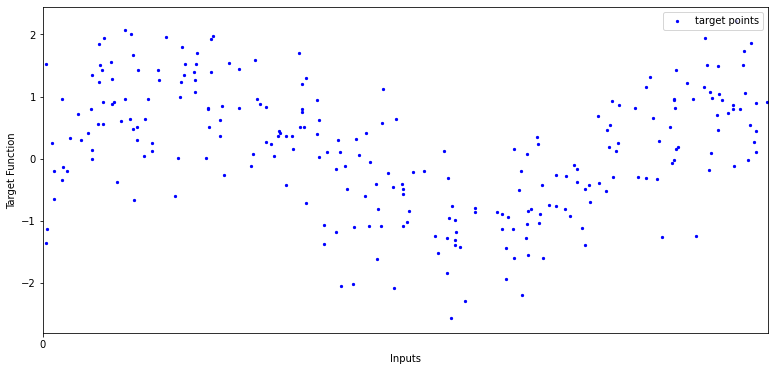

In [ ]:
fig, ax = plt.subplots(figsize=(13,6))

ax.scatter(inputs, targets, c='b', s=5, label='target points')
ax.set_xticks(range(0, 1))
plt.xlim(0, 1)
ax.set_xlabel('Inputs')
ax.set_ylabel('Target Function')
#ax.set_title(f'Distribution of sum of two different dices')
ax.legend(loc='upper right')
plt.show()

In [ ]:
# DataLoader combines a dataset and a sampler, and provides an iterable over the given dataset. The idea behind the DataLoader is to load 
# your data using multiprocessing (and pinned memory) to asynchronously push your data batch onto the GPU during training so that you can 
# basically hide the data loading time.
# TensorDataset is a convenient method to wrap already loaded tensors into a Dataset.

train_dataloader = DataLoader(TensorDataset(inputs, targets), batch_size= 256, shuffle=True)

In [ ]:

class UniversalApprox(nn.Module):
  def __init__(self, num_units, dropout_rate):
    super().__init__()

    self.num_units = num_units
    self.dropout_rate = dropout_rate

    # dropout is a function that takes as input activations from the previous layer and
    # sets some of them at zero, according to the dropout rate value.

    self.dense1 = nn.Linear(1, self.num_units, bias=True)
    self.dense2 = nn.Linear(self.num_units, int(self.num_units), bias=True)
    self.dense3 = nn.Linear(int(self.num_units), int(self.num_units / 2), bias=True)
    self.dense4 = nn.Linear(int(self.num_units/ 2), 1, bias=True)
    self.droput = nn.Dropout2d(p = self.dropout_rate)

  def forward(self, x):
    result = torch.tanh(self.dense1(x))
    result = self.droput(result)
    result = torch.tanh(self.dense2(result))
    result = self.droput(result)
    result = torch.tanh(self.dense3(result))
    result = self.droput(result)
    result = torch.tanh(self.dense4(result))
    return result

Let us define three models:

* model 1: huge model (lot of parameters) with no dropout

* model 2: huge model with dropout activated

* model 3: light model with dropout activated

In [ ]:
model_1 = UniversalApprox(num_units = 2048, dropout_rate = .0000001)
model_1.to(device) # load the model on the device (GPU)

model_2 = UniversalApprox(num_units = 2048, dropout_rate = .2)
model_2.to(device)

model_3 = UniversalApprox(num_units = 64, dropout_rate = .2)
model_3.to(device)

model_4 = UniversalApprox(num_units = 8, dropout_rate = .2)
model_4.to(device)

UniversalApprox(
  (dense1): Linear(in_features=1, out_features=8, bias=True)
  (dense2): Linear(in_features=8, out_features=8, bias=True)
  (dense3): Linear(in_features=8, out_features=4, bias=True)
  (dense4): Linear(in_features=4, out_features=1, bias=True)
  (droput): Dropout2d(p=0.2, inplace=False)
)

Let us now see the predictions for each model before training

In [ ]:
pred_model_1 = model_1(inputs.view(-1,1).to(device)).detach().to('cpu')
pred_model_2 = model_2(inputs.view(-1,1).to(device)).detach().to('cpu')
pred_model_3 = model_3(inputs.view(-1,1).to(device)).detach().to('cpu')

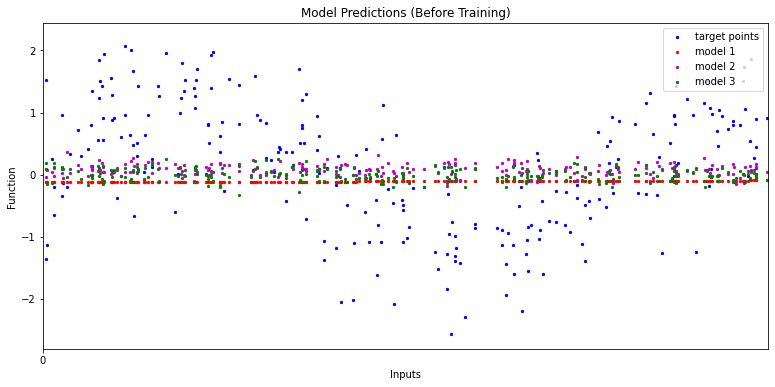

In [ ]:
fig, ax = plt.subplots(figsize=(13,6))

ax.scatter(inputs, targets, c='b', s=5, label='target points')
ax.scatter(inputs, pred_model_1, c='r', s=5, label='model 1')
ax.scatter(inputs, pred_model_2, c='m', s=5, label='model 2')
ax.scatter(inputs, pred_model_3, c='g', s=5, label='model 3')
ax.set_xticks(range(0, 1))
plt.xlim(0, 1)
ax.set_xlabel('Inputs')
ax.set_ylabel('Function')
ax.set_title(f'Model Predictions (Before Training)')
ax.legend(loc='upper right')
plt.show()

Now we define a training function that we will apply to each model. However, we must before explain an important detail. When our models have dropout or batch-normalization layers, it becomes important to specify if the model is in training or evaluation mode. During the former, these layers must be activated while during the latter they must be turned off. 

By default all the modules are initialized to train mode (self.training = True), but from now on we will always esplicitely set the training mode with `model.train()`(it is a good practice). When your model has dropout or batchnorm, you must set `model.eval()` before performing evaluation/inference.

It is worth noticing that `model.train()` and `model.eval()` do not change any behavior of the gradient calculations, but they only change the forward behaviour setting specific layers like dropout and batchnorm to evaluation mode.

In [ ]:

# Settings
num_epoch = 3000
learning_rate = 0.0001 #0.001

def training(net, criterion, optimizer, num_epochs):
    # set the model to train mode
    net.train()
    for epoch in range(num_epoch):
      for x, y in train_dataloader:
        
        # add one dimension
        x = x.view(-1, 1) 
        y = y.view(-1, 1) 

        # transfer to device
        x, y = x.to(device), y.to(device)

        model_pred = net(x)

        loss = criterion(model_pred, y)

        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

model_dict = {'model_1': model_1, 'model_2': model_2, 'model_3': model_3, 'model_4': model_4}


for model in model_dict.keys():
  print('Training {} ...'.format(model))
  criterion = nn.MSELoss(reduction = 'mean')
  optimizer = torch.optim.Adam(model_dict[model].parameters(), lr=learning_rate)
  training(model_dict[model], criterion = criterion, optimizer = optimizer,  num_epochs = num_epoch)


Training model_1 ...
Training model_2 ...
Training model_3 ...
Training model_4 ...


In [ ]:
all_preds = []

for model in model_dict.keys():
  # Disabling gradient calculation is useful for inference, since it will reduce memory 
  # consumption for computations that would otherwise have requires_grad=True.
  with torch.no_grad(): 
    model_dict[model].eval()
    pred = model_dict[model](inputs.view(-1,1).to(device)).detach().to('cpu')
    all_preds.append(pred)


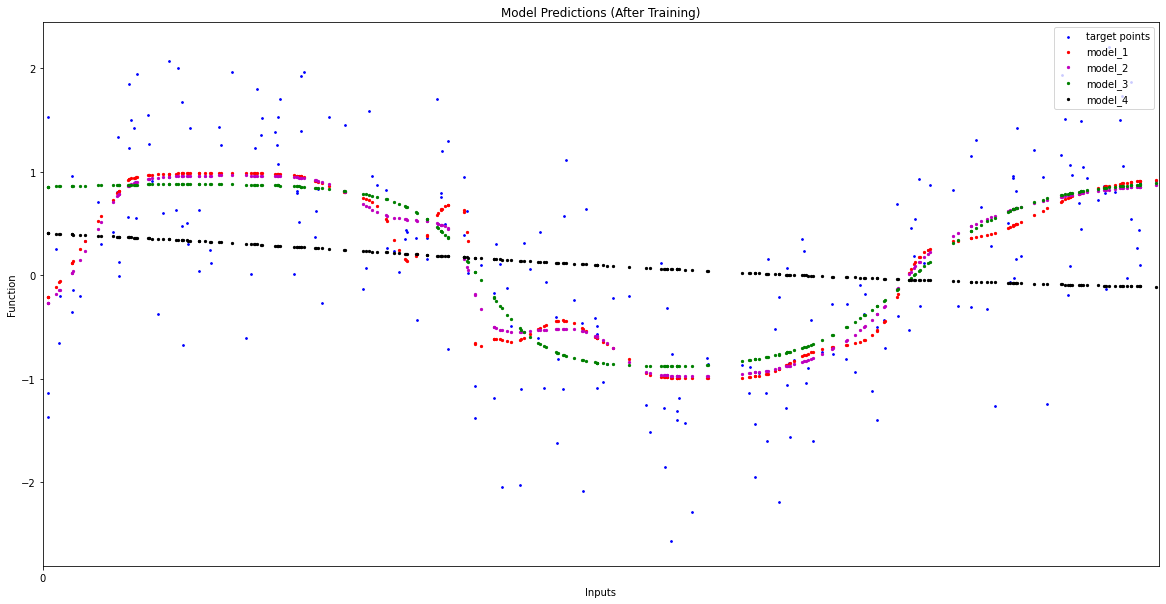

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

#pred_over = np.load('./overfitted_model.npy')
#pred_corr = np.load('./correct_model.npy')

ax.scatter(inputs, targets, c='b', s=3, label='target points')
for i, model in enumerate(model_dict.keys()):
  colors = ['r', 'm', 'g', 'k']
  ax.scatter(inputs, all_preds[i], c=colors[i], s=5, label=model)
  #ax.scatter(inputs, all_preds[1], c='m', s=5, label='model 2')
  #ax.scatter(inputs, all_preds[2], c='g', s=5, label='model 3')

ax.set_xticks(range(0, 1))
plt.xlim(0, 1)
ax.set_xlabel('Inputs')
ax.set_ylabel('Function')
ax.set_title(f'Model Predictions (After Training)')
ax.legend(loc='upper right')
plt.show()

The take home messagge is that as the model complexity increases, the models tends to fit even smaller deviations in the training data set. 

Underfitting can easily be addressed by increasing the capacity of the network, for instance the number of layers or parameters. On the other side, overfitting requires the use of specialized techniques that are called regularization techniques. We will now see some common regularizations. We have already used dropout, but let us now see it in detail

## Training, Validation and Test Sets

* **parameters:** weights and biases of a DNN which transform the input before applying the activation function. Each layer has its own set of parameters. The parameters are adjusted through backpropagation to minimize the loss function or in other words are learned during the training process;

* **hyperparameters:** unlike parameters, their values are not adapted by the learning algorithm itself. They can be viewed as settings that can be used to control the behaviour of the algorithm. Examples are number of layers, type of architecture, batch size, learning rate, etc...;

* **training set:** a set of examples used for learning. It affects parameters ann in particular they are optimized according to this set;

* **validation set:** a set of examples not seen by the model during training. It is like a mini-test set that provides feedback to the model during training on how well the current weights generalize beyond the training set. It does not impact or adjust weights directly, but providing information about overfitting it can indirectly impact weights if some regularization techniques are applied. In addition, validation set is widely used to tune hyperparameters;

* **test set:** a set of examples used at the end of training and validation to assess the predictive power of your model.

## Regularization 0: Early Stopping

Early stopping is a method that allows you to specify an arbitrarily large number of training epochs and (automatically) stop training once the model performance stops improving on the validation dataset.

<center>  <img src="https://drive.google.com/uc?export=view&id=1wBnkjXZxOzjSAA7B6RGLjLh9YVb-Mubb"width="800">  </center> 

## Regularization 1: Dropout

**What is dropout?**

Dropout is created as a regularization technique, that we can use to reduce the model capacity so that our model can achieve lower generalization error. The intuition is easy, we do not use all neurons but only turn on some neuron in each training iteration with a certain probability. If you think a bit, dropout allows to train a slightly different networks at each pass. 

In other words, dropout tries to prevent co-adaptation of neurons by shutting some neurons off during training, while in prediction it uses its full capacity. If some neurons starts to detecting the same feature repeatedly (co-adaptation), the network is not efficiently using its power. 

Mathematically, let us see how it works for a single neuron

$O_i = X_i a \left(\sum_{k=0}^d w_k x_k + b\right) = \begin{cases}
  a \left(\sum_{k=0}^d w_k x_k + b\right) & X_i = 1\\\    
  0 & X_i = 0 
\end{cases}$

where $P(X_i=0) = p$.


---



---



Let us try to see dropout effect on a tensor

In [ ]:
x = torch.tensor([[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]])

# p is the probability of an element to be zero-ed.
dropout = nn.Dropout2d(p = 0.2)

output = dropout(x)
output

tensor([[1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500, 1.2500]])

Contrary to what it is generally said, dropout does not only zero-ed with probability $p$ elements in a tensor. As we can see, the values of the output are not what we expected. To understand this issue, we recall that dropout has different behavior during training and test. Imagine a very simple model with two linear layers of size 10 and 1, respectively. If you do not use dropout (as during test), and all activations are approximatively 1, your expect the output layer value to be around 10. Now using dropout (as usually done in training) with zero-ed probability p=0.2, we will lose 1/5 of these activations, so that during training our expected value would be smaller, say 8. The idea is then to rescale each survived element with a factor $1/(1 - p) = 1.25$. Therefore, in the limit case where all elements but one are zero-ed the survivor will have a big enough value. This approach is called **inverted dropout**. [Here](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf) you can find a useful reference about dropout.

So, mathematically we can describe inverted dropout with:

$$ \text{Training}: \quad O_i = \frac{1}{1-p} X_i a \left(\sum_{k=0}^d w_k x_k + b\right) \\ 
\text{Testing}: \quad O_i = a \left(\sum_{k=0}^d w_k x_k + b\right) $$

where $P(X_i=0) = p$.

Let us now implement dropout from scratch as we described above. We will use Bernoulli disctribution for $P(X_i=0)$ that is a special case of Binomial distribution with `total_count=1`. It outputs 1 with probability `probs`, and zero with `1-probs`.So let us first check it


In [ ]:
# tensor containing our activations
x = torch.tensor([[2.0, 3.0, 5.0, 7.0, 6.0]])

# probs: probability to have 1
binomial = torch.distributions.binomial.Binomial(total_count=1, probs=1-0.2)
binomial_sample = binomial.sample(x.size())

print(binomial_sample)
print(x * binomial_sample)

tensor([[1., 1., 1., 0., 1.]])
tensor([[2., 3., 5., 0., 6.]])


In [ ]:
class MyDropout(nn.Module):
    def __init__(self, p: float = 0.5):
        super().__init__()
        if p < 0 or p > 1:
            raise ValueError("p has to be between 0 and 1, " "but got {}".format(p))
        self.p = p

    def forward(self, X):
        if self.training:
            binomial = torch.distributions.binomial.Binomial(probs=1-self.p)
            return X * binomial.sample(X.size()) * (1.0/(1-self.p))
        return X

In [ ]:
x = torch.tensor([[1.0, 1.0, 1.0, 1.0, 1.0]])

# our dropout
mydropout = MyDropout(p = 0.2)
mydropout.train() # self.training = True

mydropout(x)

tensor([[0.0000, 1.2500, 1.2500, 1.2500, 1.2500]])

In [ ]:
mydropout.eval() # self.training = False
mydropout(x)

tensor([[1., 1., 1., 1., 1.]])

## Regularization 2: Batch Normalization





Another successful normalization technique is Batch Normalization. In practice it consist of linearly transform the input to have zero mean and unit variance

* to compare features that have different magnitude (for example a feature that varies from 0 to 1 compared to another feature that varies from -100 to 0).
* to reduce overfitting (we will understand soon);
* to speed up training.

Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change. The authors of the algorithm ([here the paper!](https://arxiv.org/abs/1502.03167)) define Internal Covariate Shift as the change in the distribution of network activations due to the change in network parameters during training. Batch normalization aims to compensate this effect normalizing the activations of a layer by subtracting the batch mean and dividing by the batch standard deviation. By whitening the input (activation of the previous layer) the algorithm tries to achieve a fixed distribution of inputs that would decrease the effects of the internal covariate shift.

$$
\mu_b = \frac{1}{m} \sum_{i=1}^m x_i\\
\sigma_b^2 = \frac{1}{m} \sum_{i=1}^m (x_i - \mu_b)^2\\
\hat{x_i} = \frac{x_i - \mu_b}{\sqrt{\sigma^2_b + \epsilon}}
$$

However, after this shift/scale of activation outputs, the weights in the next layer are no longer optimal. When the optimizer tries to minimize the loss function it might learn how to undo the normalization (if this goes in a better  local minima). For this reason, batch normalization algorithm has two trainable parameters, so that the normalized output is multiplied by a "standard deviation" parameter (gamma) and is added to a "mean" parameter (beta). 

$$
\hat{y_i} = \gamma \hat{x_i} + \beta
$$

In other words, batch normalization lets the optimizer do the denormalization by changing only these two weights for each activation, instead of losing the local minima by changing all the weights (and potentially render unstable all the network).

**But, how batch normalization is related to overfitting?**

In a way, batch normalization is similar to dropout in the sense that it multiplies each hidden unit by a random value at each step of training. In this case, the random value is the standard deviation of all the hidden units in the batch. Because different examples are randomly chosen for inclusion in the batch at each step, the standard deviation randomly fluctuates. At the same time, batch normalization also subtracts a random value (the mean of the batch) from each hidden unit at each step. These sources of noise mean that the network has to learn to be robust to variations of the input, similarly to dropout.

In [ ]:
class MyBatchNorm2d(nn.Module):
    def __init__(self, gamma: float = 1.0, beta: float = 0.0):
        super().__init__()

        # two learnable parameters of Batch Norma
        self.gamma = gamma
        self.beta = beta

        # Let us define a linear layer
        self.linear = torch.nn.Linear(1, 1)
        self.linear.weight.data.fill_(self.gamma)
        self.linear.bias.data.fill_(self.beta)

    def forward(self, X):
        # first mean on axis 0 (batches), then on axis 2 (columns), then on axis 3 (row)
        mu = X.mean([0, 2, 3])
        # If unbiased is False, then the variance will be calculated via the biased estimator (without Bessel’s correction ). 
        # Otherwise, Bessel’s correction will be used.
        var = X.var([0, 2, 3], unbiased=False)

        # new normalized weights
        X_norm_tmp = (X - mu) / np.sqrt(var + 1e-8)
        X_norm = X_norm_tmp.view([12,1])

        # below nothis else than: gamma * X_norm + beta
        out = self.linear(X_norm)
        return out.view(3,1,2,2)

Let us now test that our Batch Normalization gives the same results of the built-in PyTorch function

In [ ]:
# define a tensor of dimension (batch, channel, H, W) = (3, 1, 2, 2)
X = np.array([[[[1.0, 2.0],[3.0, 4.0]]], [[[2.0, 3.0],[1, 2.5]]], [[[3.0, 4.0],[2.0, 2.5]]]])
# cast it to a torch tensor
x = torch.tensor(X).float()

# pytorch built-in function
batch_norm = nn.BatchNorm2d(1, affine=False)
# our BN version (put it in eval mode)
my_batch_norm = MyBatchNorm2d().eval()

Let us check that we correctly initialized the parameters $\gamma$ and $\beta$

In [ ]:
list(my_batch_norm.named_parameters())

[('linear.weight', Parameter containing:
  tensor([[1.]], requires_grad=True)), ('linear.bias', Parameter containing:
  tensor([0.], requires_grad=True))]

Their difference must be zero

In [ ]:
my_batch_norm(x) - batch_norm(x)



tensor([[[[-9.0599e-06, -3.0398e-06],
          [ 3.0398e-06,  9.0599e-06]]],


        [[[-3.0398e-06,  3.0398e-06],
          [-9.0599e-06,  0.0000e+00]]],


        [[[ 3.0398e-06,  9.0599e-06],
          [-3.0398e-06,  0.0000e+00]]]], grad_fn=<SubBackward0>)

## Regularization 3: L1 & L2

We already understood that overfitting occurs when a machine learning or statistics model is tailored to a particular dataset and is unable to generalize to other datasets. This usually happens in complex models, like deep neural networks.

Differently from Dropout and Batch Normalization (that are implemented into the neural network, as if they were layers), Lasso (L1) and Ridge (L2) regularizations are terms that enter into the loss function. In other words they involve adding penalties to the loss function.

The underline idea is that when a model undergoes overfitting, its weights become more specialized with respect to the training data. In particular they grow in size in order to handle the specifics of the training examples.
Large weights make the network unstable, since they tend to cause large changes in output for small changes in the inputs. Therefore, it is better to limit or constrain the possible values the model can have. This is done by adding a penalty to high values of weights, so that the space of possible models you can achieve is reduced. This is exactly what L1 and L2 do. Simpler models are less variable, hence less overfitting (but potentially more biased).



### Lasso L1 Regularization

Lasso regularization (sometimes called regularization for sparsity) performs **L1 regularization**, i.e. it adds a factor of sum of absolute value of weights in the loss function

$$L(w) = l(y_{pred}(w), y_{true}) + \alpha \sum_i^{\text{all}} |w_i|$$

L1 regularization encourages many of the coefficients in our model to be exactly 0. In particular, since the model is forced to fit data, this regularization encourages the meaningless weights to drop to zero. Only relevant features will survive (features selection). This results in sparse weight matrices.








### Ridge L2 Regularization

L2 Regularization consist of adding a factor of sum of squares of weights in the loss function

$$L(w) = l(y_{pred}(w), y_{true}) + \alpha \sum_i^{\text{all}} |w_i|^2$$

Contrary to L1, L2 regularization does not encourage sparsity but leads to a balanced minimization of the weights. L1 and L2 terms have different derivatives, $2\alpha*weight$ and $\alpha$. At each update, the L2 derivative reduces the weight by a percentage proportionally to its values. This diminishes the weight but it will still never reach zero. On the other side, L1 derivative is a constant and easily drops to zero the weight. Note that L1 is a non-differentiable term, but despite of that, there are numerical methods to minimize it. L2 instead is differentiable.

In [ ]:
model_2_regularized = UniversalApprox(num_units = 2048, dropout_rate = .2)

model_2_regularized.to(device)

criterion = nn.MSELoss(reduction = 'mean')
optimizer = torch.optim.Adam(model_2_regularized.parameters(), lr=learning_rate, weight_decay=0.001)  # L2 regularizations

training(model_2_regularized, criterion = criterion, optimizer = optimizer, num_epochs = num_epoch)

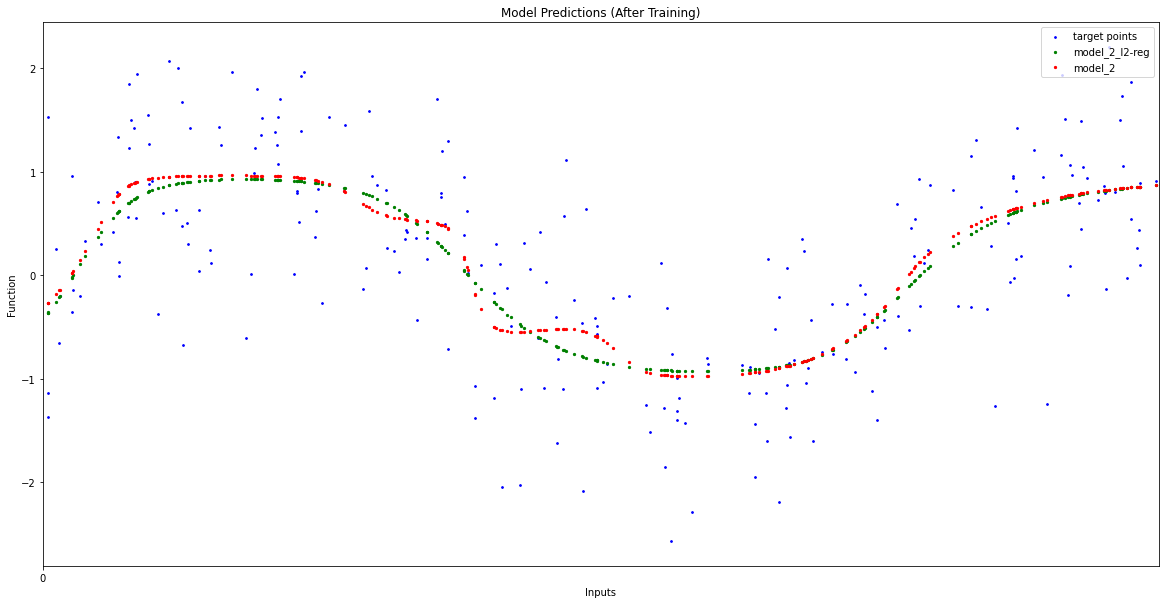

In [ ]:
model_2_regularized.eval()
pred_reg = model_2_regularized(inputs.view(-1,1).to(device)).detach().to('cpu')

model_2.eval()
pred_notreg = model_2(inputs.view(-1,1).to(device)).detach().to('cpu')


fig, ax = plt.subplots(figsize=(20,10))

#pred_over = np.load('./overfitted_model.npy')
#pred_corr = np.load('./correct_model.npy')

ax.scatter(inputs, targets, c='b', s=3, label='target points')
ax.scatter(inputs, pred_reg, c='g', s=5, label='model_2_l2-reg')
ax.scatter(inputs, pred_notreg, c='r', s=5, label='model_2')


ax.set_xticks(range(0, 1))
plt.xlim(0, 1)
ax.set_xlabel('Inputs')
ax.set_ylabel('Function')
ax.set_title(f'Model Predictions (After Training)')
ax.legend(loc='upper right')
plt.show()

## A Complete Training of LeNet CNN Model on MNIST Dataset

In this section, we want to show a complete train of a LeNet network (a simple but non-trivial CNN, [here some refs](http://yann.lecun.com/exdb/lenet/)). We will show the following pipelines

* Import, preprocess and properly normalize training and test data;
* Build up the LeNet CNN and init its weights;
* Train and evaluate the model using standard hold-out validation;
* Tune hyperparameters with Optuna;
* Train and evaluate the model using K-Fold Cross-Validation.

## Train LeNet Model with hold-out validation

### Import and Preprocess Data

Normally, digital pixels have values from $0$ to $255$. On the other side, neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. Therefore it is a good practice to normalize input to small values. We will apply the centering procedure, that consist of dividing first all pixel values by the highest value $255$. Then, we subtract the mean value and dividing by the standard deviation.

From **torchvision** we import MNIST dataset and we apply on it **transforms**, which allows a set of common image transformations that can be composed. Then we give the result to a DataLoader, that combines a dataset and a sampler, and provides an iterable over the given dataset.

As a first step, let us compute mean and standard deviation of MNIST training dataset:

In [ ]:
train_set = MNIST('./data', train=True, download=True)
test_set = MNIST('./data', train=False, download=True)

train_set_array = train_set.data.numpy() / 255.0
test_set_array = test_set.data.numpy() / 255.0

print('Train mean and std: %f  %f' %(train_set_array.mean(), train_set_array.std()))
print('Test mean and std: %f  %f' %(test_set_array.mean(), test_set_array.std()))

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning:

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)



Done!
Train mean and std: 0.130660  0.308108
Test mean and std: 0.132515  0.310480


**A good practice** is to normalize the test set using the training normalization parameters (mean and std).

We want testing data points to represent real-world data that the network has never seen. If we take the mean and variance of the whole dataset we will be introducing future information into the training explanatory variables (i.e. the mean and variance).

Therefore, you should perform feature normalisation over the training data. Then perform normalisation on testing instances as well, but this time using the mean and variance of training explanatory variables. In this way, we can test and evaluate whether our model can generalize well to new, unseen data points.

To better understand imagine now that we have trained our model and we are on a production where new data keep coming for prediction. We might not get them in mass, but one by one such as in an API call. We do not have the mean and standard deviation of those new data. We only have the mean and std during the training process.  To sum up, the goal is to be as close as possible to real problems. Therefore, during training we should not use any knowledge we get from the test data.

In [ ]:
# set the seed: built-in python, numpy, and pytorch
seed = 172
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # works for all devices (CPU and GPU)

In [ ]:
batch_size = 16

transform = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Normalize( (0.1307,), (0.3081,))])

# DataLoader: combines a dataset and a sampler, and provides an iterable over the given dataset.
train_loader = DataLoader(MNIST(root = './data', train = True, transform = transform, download=True), batch_size=batch_size , shuffle=False)
# Splitting the test images (tot 10k) in valid and test set.
valid_loader_tmp, test_loader_tmp = random_split(MNIST(root = './data', train = False, transform = transform, download=True), [7000, 3000]) 

valid_loader = DataLoader(valid_loader_tmp, batch_size=batch_size , shuffle=False)
test_loader = DataLoader(test_loader_tmp, batch_size=batch_size , shuffle=False)

### Show Image


In [ ]:
imgs, labels = next(iter(train_loader))
print(imgs.shape, labels)




torch.Size([16, 1, 28, 28]) tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7])


In [ ]:
imgs[2].shape

torch.Size([1, 28, 28])

torch.Size([1, 28, 28, 1])


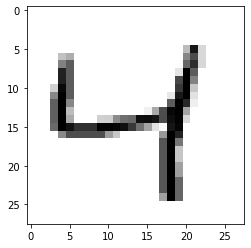

In [ ]:
image = imgs[2] # shape [1, 28, 28]
image = image.reshape([-1, 28, 28, 1])
print(np.shape(image))
plt.imshow(image.reshape([28, 28]), interpolation="nearest", cmap="gray_r")

### LeNet Model

We star with a simple CNN, the so called LeNet. The idea is to introduce a few concepts, build up a pipeline and be as clear as possible. 

In [ ]:
l = [0,1,2,3,4,5,6]
l.insert(2, 172)
l.insert(5, 172)
l

[0, 1, 172, 2, 3, 172, 4, 5, 6]

In [ ]:
class LeNet(nn.Module):
    def __init__(self, dropout_rate = .2, batch_norm = True):
        super().__init__()

        self.batch_norm = batch_norm
        self.dropout_rate = dropout_rate

        layers = [
            nn.Conv2d(1, 6, kernel_size=3), #64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Conv2d(6, 16, kernel_size=3), #128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride=2),
            nn.Dropout2d(p = self.dropout_rate)]

        if self.batch_norm == True:
            layers.insert(2, nn.BatchNorm2d(6))
            layers.insert(6, nn.BatchNorm2d(16))
          

        self.feature_extractor = nn.Sequential(*layers)
        
        self.classifier = nn.Sequential(
            nn.Linear(16*5*5, 84), #84
            nn.ReLU(),
            nn.Dropout(p = self.dropout_rate),
            nn.Linear(84, 10),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(x.shape[0], -1)
        logits = self.classifier(features)
        return logits

### Weights Initialization

We will now initialize weights (and biases) using Xavier initialization. If you are more interested in understanding its details, you can find here the origina paper by [Xavier and Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).

There are several ways to initialize parmeters. However, the most naively ones might cause vanishing gradinet effects during training. Researchers finded more safe initializations. One of them is Xavier initialization.
It sets a layer’s weights to values chosen from a random uniform distribution that is bounded between


$$\pm \frac{\sqrt{6}}{\sqrt{n_i+n_{i+1}}}, $$

where $n_i$ is the number of incoming network connections, or *fan-in*, to the layer, and $n_{i+1}$ is the number of outgoing network connections from that layer, also known as the *fan-out*. We are going to use it for weights initialization (`nn.init.xavier_uniform_(m.weight)`). For biases initialization instead we will adopt a slightly different approach, just to show you how you can play with initializations.

In [ ]:
def weight_init(m):
    torch.manual_seed(seed) 
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
            bound = 1 / np.sqrt(fan_in)
            nn.init.uniform_(m.bias, -bound, bound)

In [ ]:
lenet = LeNet(dropout_rate = 0.2, batch_norm=True)
#lenet = LeNet(dropout_rate = 0.000001, batch_norm=False)

# apply weight init
lenet.apply(weight_init)

# put the model on the device
lenet.cuda() # alternatively: lenet.to(device)


LeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout2d(p=0.2, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=84, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
# check that the model is working
summary(lenet, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
              ReLU-2            [-1, 6, 26, 26]               0
       BatchNorm2d-3            [-1, 6, 26, 26]              12
         MaxPool2d-4            [-1, 6, 13, 13]               0
            Conv2d-5           [-1, 16, 11, 11]             880
              ReLU-6           [-1, 16, 11, 11]               0
       BatchNorm2d-7           [-1, 16, 11, 11]              32
         MaxPool2d-8             [-1, 16, 5, 5]               0
         Dropout2d-9             [-1, 16, 5, 5]               0
           Linear-10                   [-1, 84]          33,684
             ReLU-11                   [-1, 84]               0
          Dropout-12                   [-1, 84]               0
           Linear-13                   [-1, 10]             850
Total params: 35,518
Trainable params: 

To keep under control all steps

In [ ]:
torch.save(lenet.state_dict(), './weights_init')

list(lenet.parameters())[0]

Parameter containing:
tensor([[[[-0.1562, -0.1802,  0.2467],
          [ 0.2934,  0.2136,  0.1818],
          [ 0.2655, -0.3056, -0.0591]]],


        [[[-0.2284, -0.1789,  0.2981],
          [-0.2880, -0.0393, -0.1080],
          [-0.1186, -0.1669, -0.2160]]],


        [[[ 0.0983, -0.0844,  0.2297],
          [-0.2784, -0.1143, -0.0104],
          [-0.2498, -0.1786,  0.2177]]],


        [[[-0.1314,  0.1066, -0.2609],
          [-0.1883,  0.1763,  0.0388],
          [-0.0899,  0.2967, -0.2992]]],


        [[[ 0.1354,  0.1173,  0.1132],
          [ 0.0986,  0.0031,  0.1644],
          [-0.1876, -0.2926,  0.2668]]],


        [[[ 0.1527,  0.0065,  0.1030],
          [-0.0440,  0.1028, -0.2853],
          [ 0.2688, -0.2156, -0.0882]]]], device='cuda:0', requires_grad=True)

### Training and Evaluation

Let us first define 

* a function that computes accuracy from logits (applying a softmax function);

* a function that computes evaluation.

Logits are the unnormalized final scores (predictions) of our model. We must apply softmax to it to get a probability distribution over our classes. If you remind, the LeNet() class returns logits



```python
class LeNet(nn.Module):
    def __init__(self, dropout_rate = .2, batch_norm = True):
          ...
          ...
          ...

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(x.shape[0], -1)
        logits = self.classifier(features)
        return logits
        
```



In [ ]:
def get_accuracy_from_logits(logits, labels):
    softmax = nn.Softmax(dim=1)
    argmax = torch.argmax(softmax(logits.float()), dim=1)
    pred_class = argmax.long()
    acc = (pred_class == labels.long()).float().mean()
    return acc

def evaluate(net, crit, dataloader, device):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)
            logits = net(data)
            mean_loss += crit(logits, labels).item()
            mean_acc += get_accuracy_from_logits(logits, labels)
            count += 1

    return mean_acc / count, mean_loss / count

In [ ]:
len(train_loader) # 3750*batch_size

3750

In [ ]:
# The SummaryWriter class is your main entry to log data for consumption and visualization by TensorBoard.
writer = SummaryWriter() # it will output to ./runs/ directory by default

def training(model, train_loader, valid_loader, optim, crit, epochs, device, model_save = True):
    # set up the model on training phase
    model.train()
    best_acc = 0
    tot_len = len(train_loader)
    for epoch in range(1, epochs + 1):
        for batch_idx, (data, labels) in enumerate(train_loader):
            # transfer data on the device
            data, labels = data.to(device), labels.to(device)
            #Clear gradients  
            # Since the backward() function accumulates gradients, and you do not want to mix up 
            # gradients between different batches, you have to zero them out at the start of a new batch.
            optim.zero_grad()
            logits = model(data)
            loss = crit(logits, labels)
            loss.backward()
            optim.step()
            if batch_idx % 200 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
                writer.add_scalars('Loss', {'train': loss.item()}, batch_idx + tot_len*(epoch-1))

            if batch_idx % 500 == 0:
                _, valid_loss = evaluate(model, crit, valid_loader, device)
                writer.add_scalars('Loss', {'valid': valid_loss}, batch_idx + tot_len*(epoch-1))
                # set again the model to train mode
                model.train()
    
        valid_acc, _ = evaluate(model, crit, valid_loader, device)
        #writer.add_scalar('Accuracy', valid_acc, tot_len + tot_len*(epoch-1))
        writer.add_scalars('Acc', {'valid': valid_acc}, tot_len + tot_len*(epoch-1))

        if valid_acc > best_acc:
          print("Best validation accuracy improved from {} to {}, saving model...".format(best_acc, valid_acc))
          best_acc = valid_acc
          if model_save:
            torch.save(model.state_dict(), 'Models/lenet_{}.pt'.format(epoch))

    return best_acc
    
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            test_loss += criterion(output, labels).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
#!rm -rf runs
#!rm -rf Models

In [ ]:
epochs = 3
!mkdir Models


Let us train the LeNet model

In [ ]:
# define loss function
criterion = nn.CrossEntropyLoss() # The input is expected to contain raw, unnormalized scores for each class (logits)

# define optimizer
optimizer = torch.optim.Adam(lenet.parameters(), lr = 0.0001) 

kwargs = {'optim': optimizer, 'crit': criterion, 
          'epochs': epochs, 'device': device}

training(lenet, train_loader, valid_loader, **kwargs)

writer.close()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.658118
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.877341
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.906877
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.992326
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.756338
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.611249
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.681029
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.531705
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.475723
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.323899
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.293203
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.303319
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.260779
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.630203
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.377947
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.258571
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.252461
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.185472
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.153833
Best validation accuracy improved from 0 to 0.9493435621261

Let us now evaluate the model on the test set

In [ ]:
# Model with Batch Normalization active
test(lenet, device = device, test_loader=test_loader)


Test set: Loss: 0.0042, Accuracy: 2933/3000 (97.8%)



In [ ]:
list(lenet.parameters())[0][0]

tensor([[[-0.1530, -0.1603,  0.2593],
         [ 0.2800,  0.2426,  0.2417],
         [ 0.2658, -0.2709, -0.0232]]], device='cuda:0',
       grad_fn=<SelectBackward>)

In [ ]:
lenet_ = LeNet(dropout_rate = 0.4, batch_norm=True) #LeNet()
lenet_.cuda()
lenet_.load_state_dict(torch.load('./weights_init'))

<All keys matched successfully>

In [ ]:
list(lenet_.parameters())[0][0]

tensor([[[-0.1562, -0.1802,  0.2467],
         [ 0.2934,  0.2136,  0.1818],
         [ 0.2655, -0.3056, -0.0591]]], device='cuda:0',
       grad_fn=<SelectBackward>)

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir runs/

## Hyperparameters Tuning with Optuna




Hyperparameter optimization is an important issue in machine learning. Parameters are learned during training, as we have seen so far. Hyperparameters are instead setup before training and they do not take part to backpropagation. Different hyperparameter setups can evolve in different performances. Therefore it is important to explore the landscape of hyperparameter combinations and find out the best one according to a choosen metric.

[Optuna](https://optuna.org/) is an open source hyperparameter optimization framework to automate hyperparameter search. Optuna is framework agnostic. You can use it with any machine learning or deep learning framework.

The main objects of an Optuna pipeline are

* a **trial** corresponds to a single execution of the objective function and it is internally instantiated upon each invocation of the function;

* **suggest methods** are called inside the objective function to obtain parameters for a trial;

* a **study object** is created to start the optimization.

In [ ]:
# let us define our objective function
def train_mnist(trial):

  # configuration
  cfg = { 'device' : "cuda" if torch.cuda.is_available() else "cpu",
          'n_epochs' : 1,
          'seed' : 0,
          'model_save' : False,
          'lr' : trial.suggest_loguniform('lr', 1e-4, 1e-2),          
          'dropout': trial.suggest_discrete_uniform('dropout', 0.1, 0.3, 0.5),
          'optimizer': trial.suggest_categorical('optimizer',[torch.optim.SGD, torch.optim.Adam]),
          'batch_norm': trial.suggest_categorical('batch_norm',[True, False]),
          }

  torch.manual_seed(cfg['seed'])
  # model
  lenet = LeNet(dropout_rate = cfg['dropout']).to(device)
  # apply weight init
  lenet.apply(weight_init)

  criterion = nn.CrossEntropyLoss()
  optimizer = cfg['optimizer'](lenet.parameters(), lr=cfg['lr'])

  best_valid_acc = training(lenet, train_loader, valid_loader, optimizer, criterion, 
                  epochs = cfg['n_epochs'], device = cfg['device'], model_save = cfg['model_save'])

  return best_valid_acc

To determine the hyperparameter values to be used in a trial, we must define e sampler. We will use `optuna.samplers.TPESampler()` that is based on Tree-structured Parzen Estimator algorithm (it makes use of Gaussian Mixture Models, more details [here](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler)). There are [several samplers](https://optuna.readthedocs.io/en/stable/reference/samplers.html), for instance also the most basic ones like `optuna.samplers.GridSampler` which suggests all combinations of parameters in the given search space during the study.

In [ ]:
import joblib

# a sampler has the responsibility to determine the parameter values to be evaluated in a trial.
sampler = optuna.samplers.TPESampler()
# You can also try 
# sampler = optuna.samplers.GridSampler()
    
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(func=train_mnist, n_trials=15)

# persist an arbitrary Python object into one file.
joblib.dump(study, './optuna_report.pkl')

[I 2020-09-09 15:11:34,924] A new study created in memory with name: no-name-c2a0f60b-8561-442b-9794-b479b465227d
/usr/local/lib/python3.6/dist-packages/optuna/distributions.py:517: UserWarning:

The distribution is specified by [0.1, 0.3] and q=0.5, but the range is not divisible by `q`. It will be replaced by [0.1, 0.1].

/usr/local/lib/python3.6/dist-packages/optuna/distributions.py:403: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.sgd.SGD'> which is of type type.

/usr/local/lib/python3.6/dist-packages/optuna/distributions.py:403: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'torch.optim.adam.Adam'> which is of type type.



Train Epoch: 1 [0/60000 (0%)]	Loss: 4.231233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.764893
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.187835
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.837062
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.531365
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.282993
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.221020
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.256928
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.214015
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.141186
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.176672
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.058201
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.429856
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.126822
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.166686
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.053149
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.037635
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.111503
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.071155
Best validation accuracy improved from 0 to 0.9640410542488

[I 2020-09-09 15:12:07,916] Trial 0 finished with value: 0.9640410542488098 and parameters: {'lr': 0.004217957959858376, 'dropout': 0.1, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'batch_norm': False}. Best is trial 0 with value: 0.9640410542488098.


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.231233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.909007
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.254495
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.925537
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.624924
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.363950
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.246350
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.284810
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.253524
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.156803
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.212615
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.061382
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.431588
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.165202
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.178158
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.066818
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.045431
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.135278
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.073637
Best validation accuracy improved from 0 to 0.9603310227394

[I 2020-09-09 15:12:40,876] Trial 1 finished with value: 0.9603310227394104 and parameters: {'lr': 0.0031840253574837735, 'dropout': 0.1, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'batch_norm': False}. Best is trial 0 with value: 0.9640410542488098.


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.231233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.548542
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.043624
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.372114
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.448614
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.046568
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.143217
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.068261
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.410157
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.018449
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.037777
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.005203
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.410337
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.070488
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.061867
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.042583
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.020897
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.027910
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.004479
Best validation accuracy improved from 0 to 0.9700341820716

[I 2020-09-09 15:13:17,908] Trial 2 finished with value: 0.9700341820716858 and parameters: {'lr': 0.0013496314462008844, 'dropout': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_norm': False}. Best is trial 2 with value: 0.9700341820716858.


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.231233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.226795
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.014624
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.244280
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.362063
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.204846
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.084826
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.126031
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.002739
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.188376
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.076911
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.108414
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.228380
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.048450
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.045463
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.128787
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.043221
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.037053
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.060665
Best validation accuracy improved from 0 to 0.9678937792778

[I 2020-09-09 15:13:55,042] Trial 3 finished with value: 0.9678937792778015 and parameters: {'lr': 0.009138748296228055, 'dropout': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_norm': False}. Best is trial 2 with value: 0.9700341820716858.


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.231233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.737453
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.142292
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.840591
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.477619
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.258423
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.264997
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.200966
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.068743
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.062365
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.178751
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.029428
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.435453
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.064927
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.115654
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.136522
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.157820
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.008607
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.004599
Best validation accuracy improved from 0 to 0.9701768755912

[I 2020-09-09 15:14:32,065] Trial 4 finished with value: 0.9701768755912781 and parameters: {'lr': 0.0004590766530999341, 'dropout': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_norm': True}. Best is trial 4 with value: 0.9701768755912781.


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.231233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.245361
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.458819
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.139655
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.734916
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.520417
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.454798
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.366873
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.169508
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.196266
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.294883
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.082817
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.300170
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.158899
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.200972
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.163077
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.222497
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.019411
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.061278
Best validation accuracy improved from 0 to 0.9586187005043

[I 2020-09-09 15:15:09,083] Trial 5 finished with value: 0.958618700504303 and parameters: {'lr': 0.00016321055039421, 'dropout': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_norm': False}. Best is trial 4 with value: 0.9701768755912781.


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.231233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 3.010260
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.357849
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.335377
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.536402
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.331409
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.115428
Train Epoch: 1 [22400/60000 (37%)]	Loss: 1.734170
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.454136
Train Epoch: 1 [28800/60000 (48%)]	Loss: 1.282772
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.144038
Train Epoch: 1 [35200/60000 (59%)]	Loss: 1.170518
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.043232
Train Epoch: 1 [41600/60000 (69%)]	Loss: 1.225429
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.430902
Train Epoch: 1 [48000/60000 (80%)]	Loss: 1.021445
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.774033
Train Epoch: 1 [54400/60000 (91%)]	Loss: 1.114071
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.935009
Best validation accuracy improved from 0 to 0.7990867495536

[I 2020-09-09 15:15:42,121] Trial 6 finished with value: 0.7990867495536804 and parameters: {'lr': 0.00016659814230979075, 'dropout': 0.1, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'batch_norm': False}. Best is trial 4 with value: 0.9701768755912781.


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.231233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.776339
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.147654
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.782851
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.496995
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.336319
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.276418
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.203813
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.053734
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.051856
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.181888
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.031296
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.438653
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.128296
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.136014
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.088342
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.194134
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.008243
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.003811
Best validation accuracy improved from 0 to 0.9673230051994

[I 2020-09-09 15:16:18,924] Trial 7 finished with value: 0.9673230051994324 and parameters: {'lr': 0.0004299548794604202, 'dropout': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_norm': False}. Best is trial 4 with value: 0.9701768755912781.


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.231233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.658823
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.080569
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.642886
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.625326
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.121114
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.186502
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.057934
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.252643
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.041508
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.049635
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.010825
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.404353
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.016482
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.054718
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.061207
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.079267
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.010446
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.009375
Best validation accuracy improved from 0 to 0.9720319509506

[I 2020-09-09 15:16:55,435] Trial 8 finished with value: 0.9720319509506226 and parameters: {'lr': 0.000860235361468209, 'dropout': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_norm': False}. Best is trial 8 with value: 0.9720319509506226.


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.231233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.547839
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.789367
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.316748
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.021559
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.722895
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.553427
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.463201
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.324415
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.267716
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.333280
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.166287
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.276478
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.223409
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.282391
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.223007
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.235133
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.039278
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.104764
Best validation accuracy improved from 0 to 0.9511985778808

[I 2020-09-09 15:17:31,870] Trial 9 finished with value: 0.9511985778808594 and parameters: {'lr': 0.00010526607009498394, 'dropout': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_norm': False}. Best is trial 8 with value: 0.9720319509506226.


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.231233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.554189
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.088104
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.480324
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.508406
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.144013
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.321510
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.048714
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.372477
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.122013
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.011991
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.011152
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.551071
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.048451
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.023031
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.176553
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.030277
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.008401
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.025646
Best validation accuracy improved from 0 to 0.9691780209541

[I 2020-09-09 15:18:08,186] Trial 10 finished with value: 0.9691780209541321 and parameters: {'lr': 0.0012051511112780475, 'dropout': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_norm': True}. Best is trial 8 with value: 0.9720319509506226.


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.231233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.755198
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.127244
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.737832
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.484605
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.259922
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.247953
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.149272
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.092439
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.045344
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.144317
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.021894
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.469650
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.044483
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.143546
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.108809
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.109393
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.019428
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.002109
Best validation accuracy improved from 0 to 0.9718892574310

[I 2020-09-09 15:18:44,336] Trial 11 finished with value: 0.9718892574310303 and parameters: {'lr': 0.0005195386267002047, 'dropout': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_norm': True}. Best is trial 8 with value: 0.9720319509506226.


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.231233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.731792
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.128313
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.806886
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.507611
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.255530
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.264506
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.146853
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.105846
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.025955
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.127266
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.026642
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.396347
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.064282
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.082637
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.079962
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.157957
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.010025
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.002179
Best validation accuracy improved from 0 to 0.9678937792778

[I 2020-09-09 15:19:20,709] Trial 12 finished with value: 0.9678937792778015 and parameters: {'lr': 0.0005021104445555263, 'dropout': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_norm': True}. Best is trial 8 with value: 0.9720319509506226.


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.231233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.662869
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.087170
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.658597
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.555994
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.179977
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.245224
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.063340
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.217585
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.060267
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.060161
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.013172
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.468376
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.022622
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.135540
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.119560
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.092129
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.030270
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.003365
Best validation accuracy improved from 0 to 0.9730308055877

[I 2020-09-09 15:19:57,078] Trial 13 finished with value: 0.9730308055877686 and parameters: {'lr': 0.0006595402688301448, 'dropout': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_norm': True}. Best is trial 13 with value: 0.9730308055877686.


Train Epoch: 1 [0/60000 (0%)]	Loss: 4.231233
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.233178
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.036070
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.320669
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.428473
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.037209
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.143872
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.126630
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.209994
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.166676
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.041766
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.073385
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.553906
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.037521
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.002214
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.214130
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.306186
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.015068
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.002198
Best validation accuracy improved from 0 to 0.9678937792778

[I 2020-09-09 15:20:33,800] Trial 14 finished with value: 0.9678937792778015 and parameters: {'lr': 0.0021307889364594788, 'dropout': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_norm': True}. Best is trial 13 with value: 0.9730308055877686.


['./optuna_report.pkl']

In [ ]:
# load the saved study
study = joblib.load('./optuna_report.pkl')
# convert in dataframe
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete'], axis=1)
df

,number,value,duration,params_batch_norm,params_dropout,params_lr,params_optimizer
0,0,0.964041,00:00:32.986281,False,0.1,0.004218,<class 'torch.optim.sgd.SGD'>
1,1,0.960331,00:00:32.950794,False,0.1,0.003184,<class 'torch.optim.sgd.SGD'>
2,2,0.970034,00:00:37.023680,False,0.1,0.001350,<class 'torch.optim.adam.Adam'>
3,3,0.967894,00:00:37.129444,False,0.1,0.009139,<class 'torch.optim.adam.Adam'>
4,4,0.970177,00:00:37.018455,True,0.1,0.000459,<class 'torch.optim.adam.Adam'>
5,5,0.958619,00:00:37.011276,False,0.1,0.000163,<class 'torch.optim.adam.Adam'>
6,6,0.799087,00:00:33.030336,False,0.1,0.000167,<class 'torch.optim.sgd.SGD'>
7,7,0.967323,00:00:36.794189,False,0.1,0.000430,<class 'torch.optim.adam.Adam'>
8,8,0.972032,00:00:36.507813,False,0.1,0.000860,<class 'torch.optim.adam.Adam'>
9,9,0.951199,00:00:36.426737,False,0.1,0.000105,<class 'torch.optim.adam.Adam'>


In [ ]:
study.best_trial

FrozenTrial(number=13, value=0.9730308055877686, datetime_start=datetime.datetime(2020, 9, 9, 15, 19, 20, 717374), datetime_complete=datetime.datetime(2020, 9, 9, 15, 19, 57, 77685), params={'lr': 0.0006595402688301448, 'dropout': 0.1, 'optimizer': <class 'torch.optim.adam.Adam'>, 'batch_norm': True}, distributions={'lr': LogUniformDistribution(high=0.01, low=0.0001), 'dropout': DiscreteUniformDistribution(high=0.1, low=0.1, q=0.5), 'optimizer': CategoricalDistribution(choices=(<class 'torch.optim.sgd.SGD'>, <class 'torch.optim.adam.Adam'>)), 'batch_norm': CategoricalDistribution(choices=(True, False))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=13, state=TrialState.COMPLETE)

In [ ]:
#optuna.visualization.plot_contour(study, params=['lr','optimizer'])
optuna.visualization.plot_optimization_history(study)

## K-Fold Cross Validation

So far, we have used holdout set for model validation that consists of splitting once and for all the whole dataset in training and validation sets. This method is widely used but can suffer from the lucky split phenomenon.

It is a good practice in machine learning to overwhelm hold-out validation and exploit cross-validation. This means that multiple rounds of train/validation are performed using different data partitions. Validation results are then averaged over the rounds to give a fair estimate of the model predictive performances. This process allows to reduce variance and avoids the lucky split phonomenon.

Let see how it works. Cross-validation is always performed on training set (Think about MNIST dataset, that has 60k samples in training set and 10K in test set). In case of k-fold cross validation, say number of samples in training set is 100 and you have taken k = 5, then train set is equally divided in 5 equal parts: p1, p2, p3, p4, p5.
Now, in first iteration/fold p1 will be left out and remaining 4 parts (p2, p3, p4, p5) will be used for training the algorithm and p1 to validate it. Once algorithm is trained this trained model will be validated on p1 from this you will get error/accuracy metric. Now in 2nd iteration/fold p2 will be left out and again algorithm will be trained on remaining 4 parts( p1, p3, p4, p5) and once algorithm is trained it gets validated on p2. It continues till all 5 iterations are over. At last you will get average train and validated error/accuracy metrics from cross validation exercise. And this is how cross-validation works and is used.

<center>  <img src="https://drive.google.com/uc?export=view&id=1qRpYnHSzc1lhutp-F3ehpEGMSSa18Eza"width="800">  </center> 


The best scenario is that our accuracy is similar in all our folds, say 92.0, 91.5, 92.0, 92.5 and 91.8. This means that our algorithm (and our data) is consistent and we can be confident that by training it on all the data set and deploy it in production will lead to similar performance.
However, we could end up in a slightly different scenario, say 92.0, 44.0, 91.5, 92.5 and 91.8. These results look very strange. It looks like one of our folds is from a different distribution, we have to go back and make sure that our data is what we think it is.

The worst scenario we can end up in is when we have considerable variation in our results, say 80, 44, 99, 60 and 87. Here it looks like that our algorithm or our data (or both) is no consistent, it could be that our algorithm is unable to learn, or our data is very complicated.


In [ ]:
transform = transforms.Compose([transforms.ToTensor(), 
                                        transforms.Normalize( (0.1307,), (0.3081,))])

train_dataset = MNIST(root = './data', train = True, transform = transform, download=True)

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5)

def cross_validation(network, optim, crit, epochs, device, batch_size = 16, model_save = False):
    final_acc = []
    for fold, (train_index, valid_index) in enumerate(kfold.split(train_dataset.data, train_dataset.targets)):
        # reset weights to init values at each fold
        network.load_state_dict(torch.load('./weights_init'))
        print(list(network.parameters())[0][0])
        
        ### Dividing data into folds
        train_fold = torch.utils.data.Subset(train_dataset, train_index)
        valid_fold = torch.utils.data.Subset(train_dataset, valid_index)

        train_loader_fold = DataLoader(train_fold, batch_size = batch_size, shuffle = False)
        valid_loader_fold = DataLoader(valid_fold, batch_size = batch_size, shuffle = False)

        #print(len(train_loader_fold))
        #print(len(valid_loader_fold))

        kwargs = {'optim': optim, 'crit': crit, 
          'epochs': epochs, 'device': device, 'model_save': model_save}
        
        valid_acc = training(network, train_loader_fold, valid_loader_fold, **kwargs)
        final_acc.append(valid_acc.to('cpu'))
        #print(final_acc)

        print('\nFold number {} , Valid Accuracy: {}\n'.format(fold + 1 , valid_acc))
    #print(final_acc)
    print('\nFinal Accuracy Mean: {} , Final Accuracy Std: {}\n'.format(np.array(final_acc).mean() , np.array(final_acc).std()))  
    return np.array(final_acc).mean(), np.array(final_acc).std()

In [ ]:
lenet = LeNet(dropout_rate = 0.2)

device = "cuda" if torch.cuda.is_available() else "cpu"
lenet.to(device)

optimizer = torch.optim.Adam(lenet.parameters(), lr = 0.00066) 
criterion = nn.CrossEntropyLoss()

kwargs = {'optim': optimizer, 'crit': criterion, 
          'epochs': 3, 'device': device, 'batch_size': 32, 'model_save': False}

cross_validation(lenet, **kwargs)

tensor([[[-0.1562, -0.1802,  0.2467],
         [ 0.2934,  0.2136,  0.1818],
         [ 0.2655, -0.3056, -0.0591]]], device='cuda:0',
       grad_fn=<SelectBackward>)
Train Epoch: 1 [0/48000 (0%)]	Loss: 3.149100
Train Epoch: 1 [6400/48000 (13%)]	Loss: 0.763499
Train Epoch: 1 [12800/48000 (27%)]	Loss: 0.216688
Train Epoch: 1 [19200/48000 (40%)]	Loss: 0.373426
Train Epoch: 1 [25600/48000 (53%)]	Loss: 0.193764
Train Epoch: 1 [32000/48000 (67%)]	Loss: 0.053987
Train Epoch: 1 [38400/48000 (80%)]	Loss: 0.666700
Train Epoch: 1 [44800/48000 (93%)]	Loss: 0.198721
Best validation accuracy improved from 0 to 0.9674166440963745, saving model...
Train Epoch: 2 [0/48000 (0%)]	Loss: 0.055065
Train Epoch: 2 [6400/48000 (13%)]	Loss: 0.083243
Train Epoch: 2 [12800/48000 (27%)]	Loss: 0.064931
Train Epoch: 2 [19200/48000 (40%)]	Loss: 0.025287
Train Epoch: 2 [25600/48000 (53%)]	Loss: 0.100971
Train Epoch: 2 [32000/48000 (67%)]	Loss: 0.134662
Train Epoch: 2 [38400/48000 (80%)]	Loss: 0.265231
Train Epoch: 2 [

(0.9824333, 0.002000276)

Cross validation is finished and now it is time to test the model on the test dataset

In [ ]:
test(model=lenet, device=device, test_loader=test_loader)



Test set: Average loss: 0.0027, Accuracy: 2955/3000 (98.5%)



Since we are dealing with a multi-class classification (10 classes), let us check

In [ ]:
def confusion_matrix_data(model, device, test_loader):
    model.eval()

    all_preds = np.array([])
    all_labels = np.array([])
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            output = model(data)
            preds = output.argmax(dim=1, keepdim=True) 
            # transfer to cpu and reshape preds from [[1],[2],[3]] to [1,2,3]
            preds = preds.to('cpu').detach().numpy().reshape(-1)
            labels = labels.to('cpu').detach().numpy()

            all_preds = np.concatenate((all_preds, preds), axis=0)
            all_labels = np.concatenate((all_labels, labels), axis=0)

    return all_preds, all_labels

In [ ]:
from sklearn import metrics

preds, labels = confusion_matrix_data(model=lenet, device=device, test_loader=test_loader)

cm = metrics.confusion_matrix(preds, labels)

cm

array([[302,   0,   1,   0,   1,   0,   1,   0,   0,   1],
       [  0, 355,   0,   0,   0,   0,   2,   1,   0,   1],
       [  1,   0, 304,   1,   0,   0,   0,   3,   0,   0],
       [  0,   0,   0, 281,   0,   5,   0,   0,   2,   2],
       [  0,   0,   0,   0, 293,   0,   0,   0,   2,   2],
       [  0,   0,   0,   1,   0, 266,   1,   0,   0,   3],
       [  0,   0,   0,   0,   0,   1, 301,   0,   0,   0],
       [  1,   0,   3,   0,   0,   0,   0, 276,   2,   0],
       [  2,   1,   2,   1,   0,   2,   0,   0, 268,   3],
       [  0,   0,   0,   0,   0,   0,   0,   1,   0, 304]])

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       306
         1.0       0.99      1.00      0.99       356
         2.0       0.98      0.98      0.98       310
         3.0       0.97      0.99      0.98       284
         4.0       0.99      1.00      0.99       294
         5.0       0.98      0.97      0.98       274
         6.0       1.00      0.99      0.99       305
         7.0       0.98      0.98      0.98       281
         8.0       0.96      0.98      0.97       274
         9.0       1.00      0.96      0.98       316

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



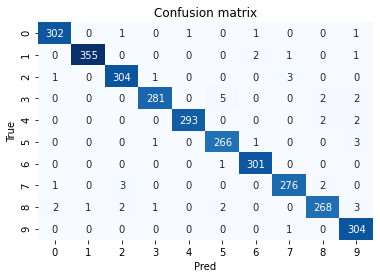

In [ ]:
## Plot multi-class metrics and confusion matrix 
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(metrics.classification_report(labels, preds))

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")

plt.show()